# Breast Cancer Classification with Pytorch

In [1]:
import torch

# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA (GPU) is available
print("CUDA available:", torch.cuda.is_available())

# If CUDA is available, print details
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())

PyTorch version: 2.7.0+cu118
CUDA available: True
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
Device count: 1
Current device: 0


## Load module

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load and Prepare Data

mean radius     0
mean texture    0
class           0
dtype: int64


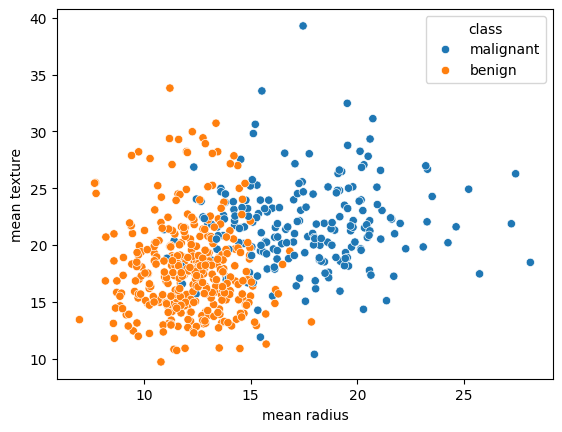

In [2]:
# Load the breast cancer dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data[:, 0:2], columns=cancer.feature_names[0:2])
df['class'] = cancer.target

# Convert label class from 0,1 to description
target = {0: 'malignant', 1: 'benign'}
df['class'] = df['class'].map(target)

# Check for null values
print(df.isnull().sum())

# Visualization
sns.scatterplot(x='mean radius', y='mean texture', hue='class', data=df)
plt.show()

## Label encoding

In [3]:
# Encode label class
class_names, y = np.unique(df['class'], return_inverse=True)
X = df.drop('class', axis=1)

# Standard Scale
sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Prepare Train and Test Data

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.25, random_state=1)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [5]:
print(X_test_tensor[:10])

tensor([[ 0.1598, -1.2356],
        [-0.2719, -0.1465],
        [-0.3344, -0.7609],
        [ 1.1879, -0.1651],
        [ 0.2848,  2.4482],
        [ 0.5773,  0.5237],
        [ 1.4379, -0.7795],
        [ 1.1226,  0.5935],
        [-1.0359,  0.1327],
        [ 0.1144, -1.2356]])


## Create a Neural Network Model

In [6]:
class CancerModel(nn.Module):
    def __init__(self):
        super(CancerModel, self).__init__()
        self.fc1 = nn.Linear(2, 32)  # Input layer to hidden layer
        self.fc2 = nn.Linear(32, 1)   # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Activation function
        x = torch.sigmoid(self.fc2(x)) # Output layer with sigmoid
        return x

# Instantiate the model
model = CancerModel()


## Compile the Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the learning rate scheduler
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by a factor of 0.1 every 5 

# option
"""
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.SGD(model.parameters(), lr=0.1)
"""

'\ncriterion = nn.MSELoss()  # Mean Squared Error\noptimizer = optim.SGD(model.parameters(), lr=0.1)\n'

## Train model

In [13]:
import time

start = time.time()

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass
    outputs = model(X_train_tensor).squeeze()  # Get predictions
    loss = criterion(outputs, y_train_tensor.float())  # Calculate loss

    # Backward pass and optimization
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

    # Step the scheduler
    # scheduler.step()

    if (epoch + 1) % 5 == 0:  # Print every 5 epochs
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

end = time.time()

print(f'Time: {end-start:.3f} s')

Epoch [5/500], Loss: 0.2498
Epoch [10/500], Loss: 0.2495
Epoch [15/500], Loss: 0.2493
Epoch [20/500], Loss: 0.2491
Epoch [25/500], Loss: 0.2488
Epoch [30/500], Loss: 0.2486
Epoch [35/500], Loss: 0.2484
Epoch [40/500], Loss: 0.2482
Epoch [45/500], Loss: 0.2479
Epoch [50/500], Loss: 0.2477
Epoch [55/500], Loss: 0.2475
Epoch [60/500], Loss: 0.2473
Epoch [65/500], Loss: 0.2470
Epoch [70/500], Loss: 0.2468
Epoch [75/500], Loss: 0.2466
Epoch [80/500], Loss: 0.2464
Epoch [85/500], Loss: 0.2461
Epoch [90/500], Loss: 0.2459
Epoch [95/500], Loss: 0.2457
Epoch [100/500], Loss: 0.2455
Epoch [105/500], Loss: 0.2453
Epoch [110/500], Loss: 0.2451
Epoch [115/500], Loss: 0.2448
Epoch [120/500], Loss: 0.2446
Epoch [125/500], Loss: 0.2444
Epoch [130/500], Loss: 0.2442
Epoch [135/500], Loss: 0.2440
Epoch [140/500], Loss: 0.2438
Epoch [145/500], Loss: 0.2436
Epoch [150/500], Loss: 0.2434
Epoch [155/500], Loss: 0.2432
Epoch [160/500], Loss: 0.2430
Epoch [165/500], Loss: 0.2428
Epoch [170/500], Loss: 0.2426


## Evaluate the Model

In [14]:
# Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred_pr = model(X_test_tensor).squeeze()
    y_pred = (y_pred_pr > 0.5).float()  # Apply threshold

# Calculate accuracy
accuracy = (y_pred == y_test_tensor).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

# Display the first few predictions
print(y_pred[:5])

Test Accuracy: 0.8601
tensor([0., 0., 0., 1., 1.])


## Saving the Model

In [17]:
model_path = '../models/cancer_model.pth'

In [15]:
# Save the model
torch.save(model.state_dict(), model_path)
print("Model saved successfully!")


Model saved successfully!


## Loading the Model

In [ ]:
# Load the model
loaded_model = CancerModel()  # Create a new instance of the model
loaded_model.load_state_dict(torch.load(model_path, map_location=device))  # Load the saved parameters
loaded_model.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")

Model loaded successfully!


## Making Predictions with the Loaded Model

In [19]:
# Predicting with the loaded model
with torch.no_grad():
    y_pred_pr_loaded = loaded_model(X_test_tensor).squeeze()
    y_pred_loaded = (y_pred_pr_loaded > 0.5).float()  # Apply threshold

# Display the first few predictions from the loaded model
print(y_pred_loaded[:5])

tensor([0., 0., 0., 1., 1.])


# Another method

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np

# --- 1. Generate Mock Data to make the example runnable ---
# This is equivalent to your X_train and y_train_1h
# The number of features is 4, as per your input_shape=(X_train.shape[1],)
# The number of classes is 3, as per your y_train_1h.shape[1]
# We'll generate 100 samples for this example.
num_samples = 100
num_features = 4
num_classes = 3
X_train_np = np.random.rand(num_samples, num_features).astype(np.float32)
y_train_np = np.random.randint(0, num_classes, size=(num_samples,), dtype=np.int64)

# Convert NumPy arrays to PyTorch Tensors
X_train = torch.from_numpy(X_train_np)
y_train = torch.from_numpy(y_train_np)

# --- 2. Define the Model using nn.Sequential ---
# This is the PyTorch equivalent of your Keras Sequential model.
# nn.Linear is the equivalent of a Dense layer.
# We'll use nn.ReLU and nn.Softmax for activation functions.
model = nn.Sequential(
    # First layer with 4 input features and 64 nodes
    nn.Linear(num_features, 64),
    nn.ReLU(),
    # Output layer with 64 input features and 3 output nodes
    nn.Linear(64, num_classes),
    # Note: nn.CrossEntropyLoss is often used without a final activation layer
    # like softmax because it includes log_softmax internally for numerical stability.
    # However, for direct comparison, we'll keep the softmax layer here.
    nn.Softmax(dim=1)
)

# --- 3. Define Loss Function and Optimizer ---
# This is equivalent to your model.compile()
# For a classification task, we use CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()
# For the optimizer, we use Adam, same as in your example.
optimizer = optim.Adam(model.parameters(), lr=0.001) # You can set the learning rate here


# Here is the addition for the learning rate scheduler!
# It monitors the validation loss and reduces the learning rate by a factor of 0.1
# if the loss doesn't improve for 5 consecutive epochs (patience=5).
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# --- 4. Manual Training Loop (The equivalent of model.fit()) ---
epochs = 100
batch_size = 8
validation_split = 0.25

# Create a validation set
val_size = int(num_samples * validation_split)
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train = X_train[val_size:]
y_train = y_train[val_size:]

print("Starting training...")
for epoch in range(epochs):
    # Set the model to training mode (important for layers like Dropout)
    model.train()
    
    # Iterate over the training data in batches
    for i in range(0, len(X_train), batch_size):
        # Extract a mini-batch
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        # Zero the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Update the model's weights
        optimizer.step()

    # --- 5. Validation Loop (Equivalent to validation_split) ---
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        
        # Calculate accuracy for validation
        _, predicted = torch.max(val_outputs.data, 1)
        correct = (predicted == y_val).sum().item()
        val_accuracy = 100 * correct / val_size
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training complete!")